# Veridi Logistics: Last Mile Logistics Auditor
This notebook contains the data analysis and cleaning pipeline for the internal audit of Veridi Logistics' last-mile delivery operations.

## 1. Import Dependencies

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Global Path Configuration

In [23]:
path = '/content/drive/MyDrive/Olist-data/'

## 3. Load Datasets
Load the Olist Brazilian E-Commerce datasets.

In [24]:
df_orders = pd.read_csv(path + 'olist_orders_dataset.csv')
df_reviews = pd.read_csv(path + 'olist_order_reviews_dataset.csv')
df_customers = pd.read_csv(path + 'olist_customers_dataset.csv')
df_products = pd.read_csv(path + 'olist_products_dataset.csv')
df_items = pd.read_csv(path + 'olist_order_items_dataset.csv')
df_translation = pd.read_csv(path + 'product_category_name_translation.csv')

# Print shapes to verify they loaded correctly
print(df_orders.shape, df_reviews.shape, df_customers.shape, df_products.shape, df_items.shape)


(99441, 8) (99224, 7) (99441, 5) (32951, 9) (112650, 7)


## 4. Data Cleaning: Deduplicating Reviews
**Decision:** The `olist_order_reviews_dataset` contained multiple reviews for single orders (due to customers updating ratings or separate item reviews). To prevent a 1-to-many relationship from inflating the master dataset row count, reviews were sorted by `review_creation_date` descending, and duplicates were dropped keeping only the most recent review per `order_id`.

In [25]:
# 1. Deduplicate reviews (Keep the most recent review per order)
df_reviews['review_creation_date'] = pd.to_datetime(df_reviews['review_creation_date'])
df_reviews_dedup = df_reviews.sort_values(by=['order_id', 'review_creation_date'], ascending=[True, False])\
                             .drop_duplicates(subset=['order_id'], keep='first')

# 2. Join Orders and Customers
df_delivered = pd.merge(df_orders, df_customers, on='customer_id', how='left')

# 3. Join with deduplicated Reviews
df_delivered = pd.merge(df_delivered, df_reviews_dedup[['order_id', 'review_score']], on='order_id', how='left')

# 4. Confirm no duplicate order_ids!
duplicates = df_delivered['order_id'].duplicated().sum()
print(f"Shape: {df_delivered.shape}")
print(f"Duplicate order_ids in master: {duplicates}")


Shape: (99441, 13)
Duplicate order_ids in master: 0


## 5. Calculate Delivery Delays & Filter Invalid Orders
**Datetime Parsing:** All temporal columns were explicitly cast to datetime objects. `days_difference` was calculated by extracting and comparing the `.date` components, effectively ignoring time-of-day variations (which add noise to a daily-level metric).

**Filtering Invalid Orders:** Canceled and unavailable orders, as well as orders missing actual delivery dates, were excluded from the delay analysis, as they represent fulfillment failures rather than measurable delivery delays.

In [26]:
# 1. Parse datetime columns explicitly
df_delivered['order_purchase_timestamp'] = pd.to_datetime(df_delivered['order_purchase_timestamp'])
df_delivered['order_estimated_delivery_date'] = pd.to_datetime(df_delivered['order_estimated_delivery_date'])
df_delivered['order_delivered_customer_date'] = pd.to_datetime(df_delivered['order_delivered_customer_date'])

# 2. Filter out canceled/unavailable orders and missing delivery dates
valid_status = ['delivered']
df_delivered = df_delivered[
    (df_delivered['order_status'].isin(valid_status)) &
    (df_delivered['order_delivered_customer_date'].notna()) &
    (df_delivered['order_estimated_delivery_date'].notna())
].copy()

# 3. Calculate days_difference (positive = late)
df_delivered['days_difference'] = (df_delivered['order_delivered_customer_date'].dt.floor('D') -
                                df_delivered['order_estimated_delivery_date'].dt.floor('D')).dt.days


# 4. Classify orders
def classify_delay(days):
    if days <= 0:
        return 'On Time'
    elif days <= 5:
        return 'Late'
    else:
        return 'Super Late'

df_delivered['delivery_status'] = df_delivered['days_difference'].apply(classify_delay)

print(df_delivered['delivery_status'].value_counts(normalize=True) * 100)


delivery_status
On Time       93.226910
Super Late     3.901731
Late           2.871359
Name: proportion, dtype: float64


## 6. Geographic Analysis: % Late Orders by Brazilian State
Calculate the late delivery rates grouped by customer state to determine if delivery issues are localized to specific regions or represent a nationwide problem.

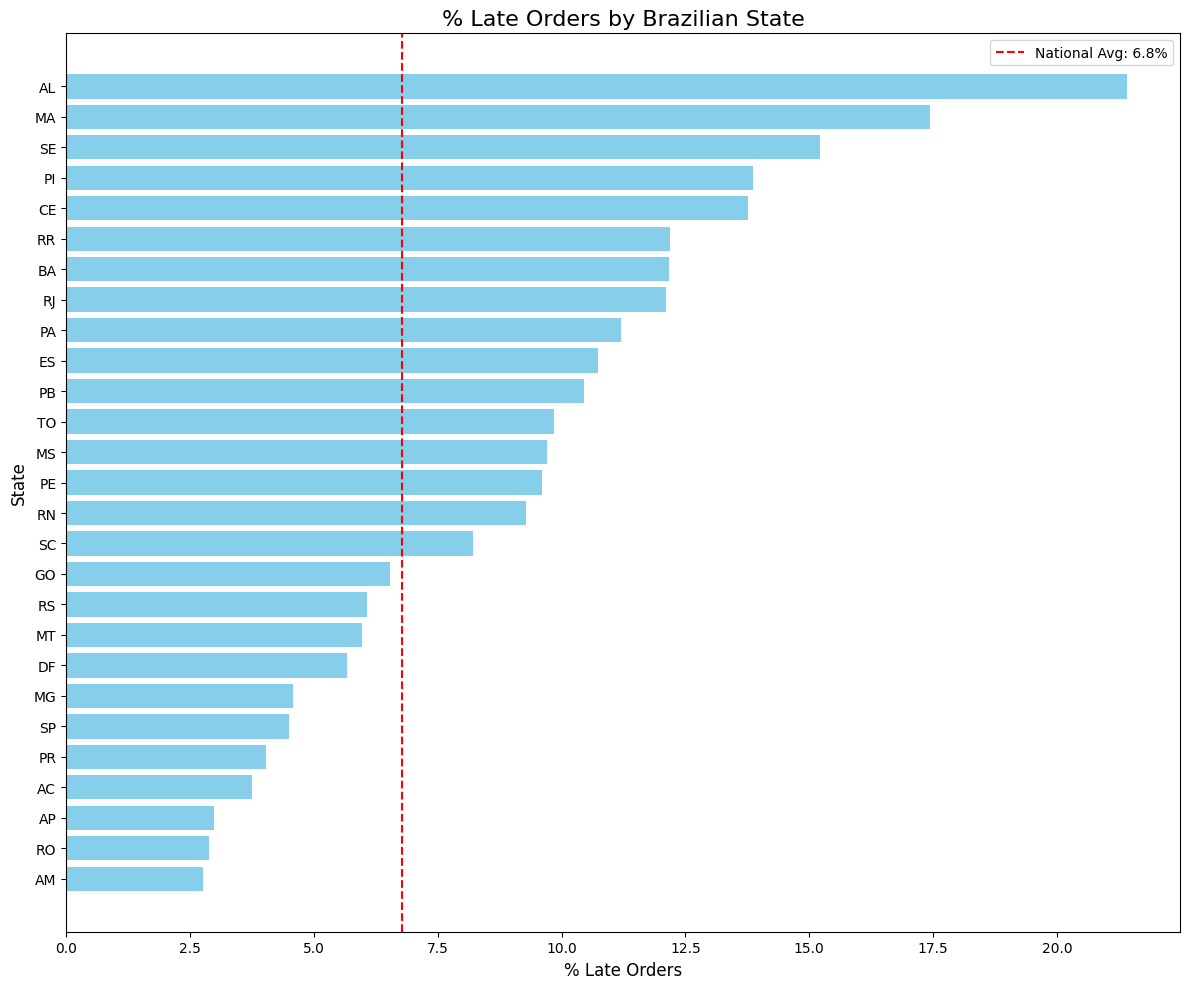

In [27]:
# Create a simple 1 or 0 flag for late deliveries
df_delivered['is_late'] = df_delivered['delivery_status'].isin(['Late', 'Super Late']).astype(int)

# Calculate state-level late rates
state_late_rate = df_delivered.groupby('customer_state')['is_late'].mean().reset_index()
state_late_rate['is_late'] *= 100  # Convert to percentage
state_late_rate = state_late_rate.sort_values('is_late', ascending=True)

# Calculate the national average
national_avg = df_delivered['is_late'].mean() * 100

# Plot Horizontal Bar Chart
plt.figure(figsize=(12, 10))
bars = plt.barh(state_late_rate['customer_state'], state_late_rate['is_late'], color='skyblue')

# Add the red dotted line for the national average!
plt.axvline(national_avg, color='red', linestyle='--', label=f'National Avg: {national_avg:.1f}%')

plt.title('% Late Orders by Brazilian State', fontsize=16)
plt.xlabel('% Late Orders', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('late_by_state.png', dpi=300)
plt.show()


## 7. Customer Sentiment vs. Delivery Delays
Analyze the relationship between delivery status (On Time, Late, Super Late) and customer satisfaction (Average Review Score). The data reveals a strong negative correlation between delivery delays and customer review scores, underscoring the critical need to optimize fulfillment networks to preserve customer sentiment.

  delivery_status  review_score
0            Late      2.989346
1         On Time      4.290353
2      Super Late      1.736267


/tmp/ipython-input-1094/3471589647.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment, x='delivery_status', y='review_score', palette='RdYlBu_r',


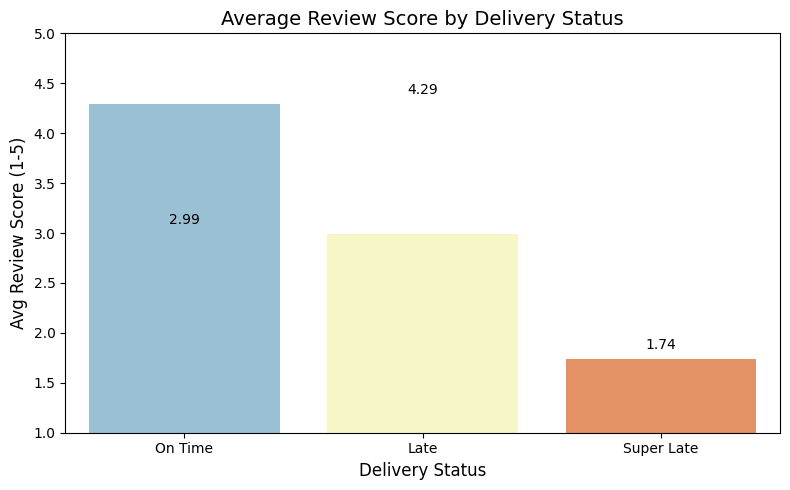

In [28]:
# Create the sentiment summary dataframe
sentiment = df_delivered.groupby('delivery_status')['review_score'].mean().reset_index()
print(sentiment)

plt.figure(figsize=(8, 5))
# Plot the bar chart
sns.barplot(data=sentiment, x='delivery_status', y='review_score', palette='RdYlBu_r',
            order=['On Time', 'Late', 'Super Late'])

plt.title('Average Review Score by Delivery Status', fontsize=14)
plt.ylabel('Avg Review Score (1-5)', fontsize=12)
plt.xlabel('Delivery Status', fontsize=12)

# Set the y-axis to match the 1-5 star rating
plt.ylim(1, 5)

# This loop prints the exact review score number above each bar!
for i, v in enumerate(sentiment['review_score']):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.savefig('sentiment_correlation.png', dpi=300)
plt.show()


## 8. Category Translation & Top 15 Delayed Categories
**Category Translation:** Product categories were aggregated at the item level. To prevent row duplication when joining back to the master table (which is unique per order), the top 15 delayed categories analysis was grouped independently.

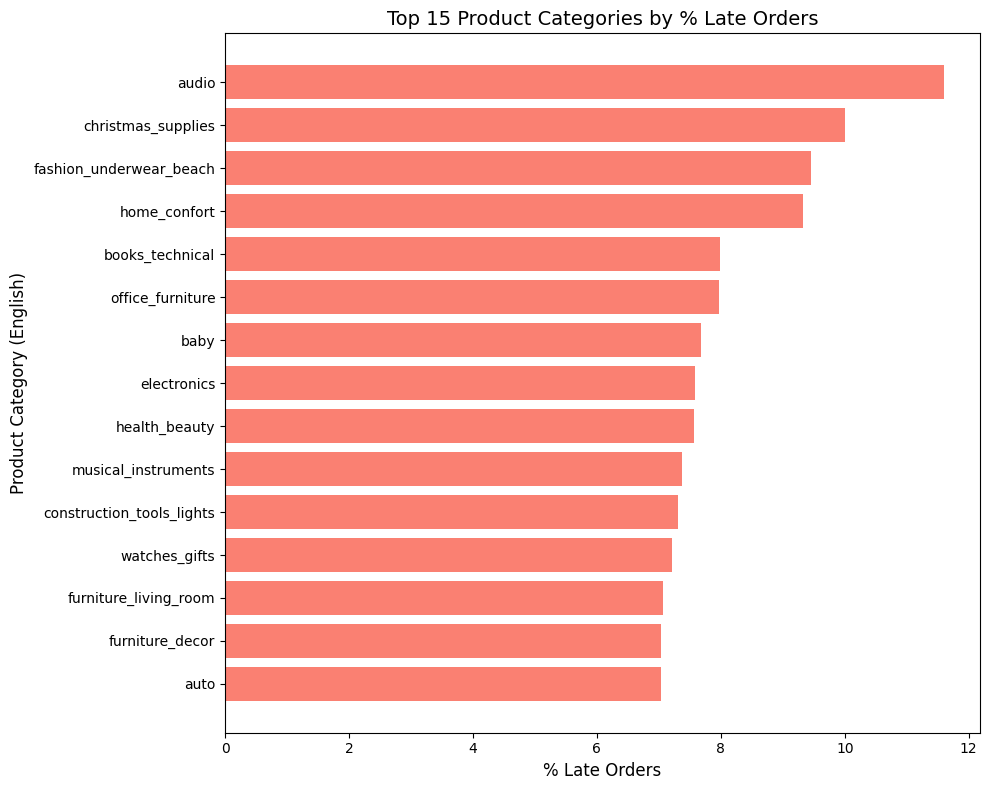

In [29]:
# 1. Join items to products to get the Portuguese category name
df_items_prod = pd.merge(df_items, df_products[['product_id', 'product_category_name']], on='product_id', how='left')

# 2. Join that result to the translation table to get the English name
df_items_trans = pd.merge(df_items_prod, df_translation, on='product_category_name', how='left')

# 3. Merge those translated categories back to your main dataframe (df_delivered) so you can see if the order was late
df_category_analysis = pd.merge(df_items_trans[['order_id', 'product_category_name_english']],
                                df_delivered[['order_id', 'is_late']],
                                on='order_id', how='inner')

# 4. Calculate the late rate specifically by product category
cat_late_rate = df_category_analysis.dropna(subset=['product_category_name_english'])\
                                    .groupby('product_category_name_english')\
                                    .agg(late_rate=('is_late', 'mean'), count=('order_id', 'count'))\
                                    .reset_index()

# Filter to categories with at least 50 orders (removes super rare items that skew the data)
cat_late_rate = cat_late_rate[cat_late_rate['count'] >= 50]
cat_late_rate['late_rate'] *= 100

# Get the Top 15 worst categories (the highest late rates)
top_15_cats = cat_late_rate.sort_values('late_rate', ascending=False).head(15).sort_values('late_rate', ascending=True)

# 5. Plot it as a horizontal bar chart!
plt.figure(figsize=(10, 8))
plt.barh(top_15_cats['product_category_name_english'], top_15_cats['late_rate'], color='salmon')
plt.title('Top 15 Product Categories by % Late Orders', fontsize=14)
plt.xlabel('% Late Orders', fontsize=12)
plt.ylabel('Product Category (English)', fontsize=12)
plt.tight_layout()
plt.savefig('top_categories.png', dpi=300)
plt.show()


## 9. Monthly Trend Analysis (Dual-Axis Chart)
**Candidate's Choice Justification:**
A monthly trend visualization comparing the percentage of late orders against the average review score over time.
*   **Business Value:** Logistics chains often suffer from seasonal bottlenecks (e.g., Black Friday, holidays). By mapping delay spikes to timeline events, leadership can proactively allocate overflow resources for peak months.
*   **Metric Relationship:** Charting the average review score on a secondary axis vividly illustrates the direct, lagging impact that operational failures have on customer satisfaction.

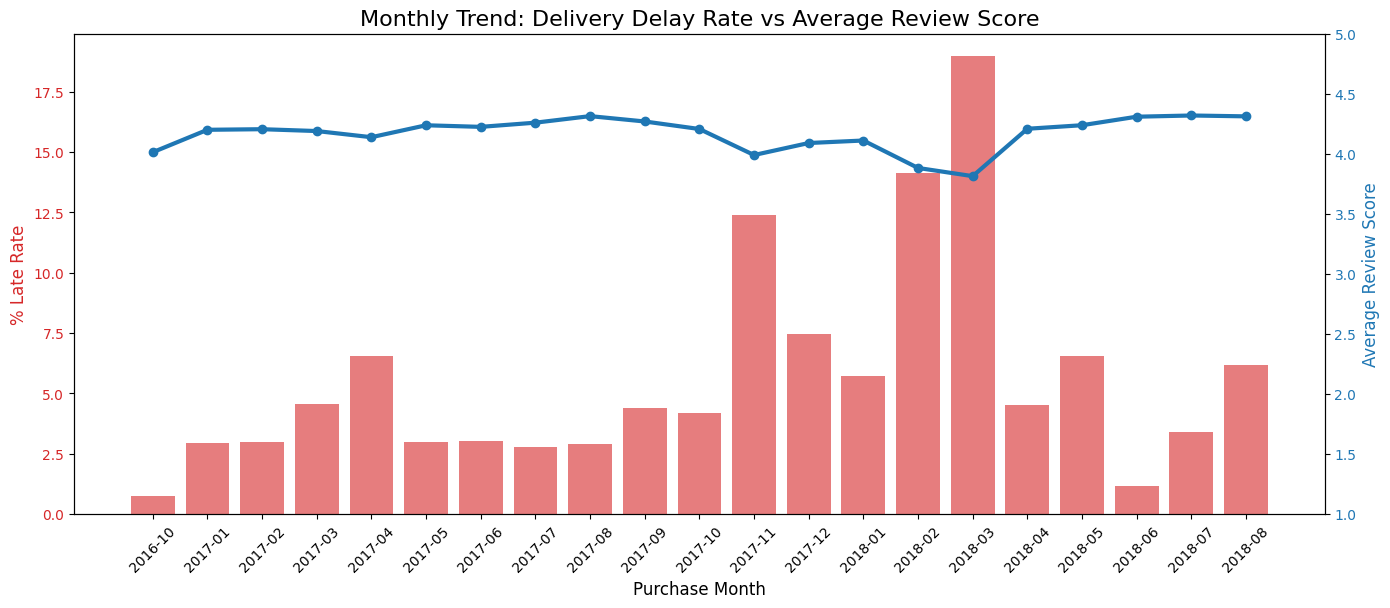

In [31]:
# 1. Create purchase_month (YYYY-MM)
df_delivered['purchase_month'] = df_delivered['order_purchase_timestamp'].dt.to_period('M').astype(str)

# 2. Group by month and calculate both Late Rate AND Average Score
monthly_trends = df_delivered.groupby('purchase_month').agg(
    late_rate=('is_late', 'mean'),
    avg_score=('review_score', 'mean'),
    order_count=('order_id', 'count')
).reset_index()

monthly_trends['late_rate'] *= 100

# 3. Filter out months with very few orders (removes noise from the first/last month of the dataset)
monthly_trends = monthly_trends[monthly_trends['order_count'] > 100]

# 4. Plot the Dual-Axis Chart
fig, ax1 = plt.subplots(figsize=(14, 6))

# Axis 1 (Left Side) - The Bar Chart for % Late
color = 'tab:red'
ax1.set_xlabel('Purchase Month', fontsize=12)
ax1.set_ylabel('% Late Rate', color=color, fontsize=12)
ax1.bar(monthly_trends['purchase_month'], monthly_trends['late_rate'], color=color, alpha=0.6, label='% Late')
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(rotation=45)

# Axis 2 (Right Side) - The Line Chart for Average Score
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Average Review Score', color=color, fontsize=12)
ax2.plot(monthly_trends['purchase_month'], monthly_trends['avg_score'], color=color, marker='o', linewidth=3, label='Avg Score')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(1, 5) # Keep review score scaled between 1 and 5!

fig.tight_layout()
plt.title('Monthly Trend: Delivery Delay Rate vs Average Review Score', fontsize=16)
fig.savefig('monthly_trends.png', dpi=300)
plt.show()


## 10. Export Master Dataset
Generate the final, cleaned master dataset (`veridi_master_clean.csv`) containing only the required columns to power the interactive Streamlit dashboard efficiently.

In [32]:
# 1. To get product_category_en for the master file, we take the first item's category per order
order_categories = df_items_trans[['order_id', 'product_category_name_english']].dropna()\
                                 .drop_duplicates(subset=['order_id'], keep='first')

# 2. Join it to your master dataframe (df_delivered)
df_final = pd.merge(df_delivered, order_categories, on='order_id', how='left')
df_final.rename(columns={'product_category_name_english': 'product_category_en'}, inplace=True)

# 3. Select ONLY the columns we need for the dashboard to keep the file size small and fast!
columns_to_export = [
    'order_id', 'order_status', 'customer_state', 'customer_city',
    'order_purchase_timestamp', 'order_estimated_delivery_date',
    'order_delivered_customer_date', 'days_difference',
    'delivery_status', 'review_score', 'product_category_en', 'purchase_month'
]

df_export = df_final[columns_to_export]

# 4. Export the single, clean master file to your Google Drive folder!
df_export.to_csv('/content/drive/MyDrive/Olist-data/veridi_master_clean.csv', index=False)
print("Exported complete! Rows:", len(df_export))


Exported complete! Rows: 96470
